In [2]:
import sys
sys.path.append('../algorithms')
sys.path.append('../datasets')

import torch

import matplotlib.pyplot as plt

from datasets import HSIDataset
from tvprior import TVPrior
from nabla import nabla

from torchvision import transforms
from math import sqrt


In [3]:
# Define device (default is "cpu")
device = "cpu"

# Define dtype
dtype = torch.float64

# Define random seed
seed = 42
torch.manual_seed(seed)

# Define data path
data_path = '/home/y/Documents/Data/HSI/datasets/harvard.zarr'


In [4]:
# Loads ENMAP Hypecnet Datasets 

val_transform = transforms.Compose([transforms.ToTensor()]) # Transforms a the input data to torch tensors
dataset = HSIDataset(root_dir=data_path, split='train', transform=val_transform)


# Choose the index of the selected image in the dataset (ENMAP dataset contains 11 000 images)
idx = 0
x = dataset[idx].unsqueeze(0).to(device=device, dtype=dtype) # import image to device (cpu or gpu), sizes of x is [1,number of bands, width, height]
# Adds a small amount of white gaussian noise to the input HSI (sigma2 = 1e-4)
x += torch.rand_like(x, device=device, dtype=dtype)*1e-2/torch.norm(x)

# Compute the panchromatic image from the ground truth HSI
panc = torch.sum(x, dim=1).unsqueeze(1)/x.shape[1]

# Adds noise to the input HSI
SNR = 10

sigma2 = 10**(-SNR/10) * torch.norm(x, dim=[2,3])**2 / x.shape[2] / x.shape[3]
sigma2 = sigma2.unsqueeze(0).unsqueeze(1).reshape(1, sigma2.numel(), 1, 1)
sigma2 = sigma2.repeat(1, 1, x.shape[2], x.shape[3])

y = x + torch.sqrt(sigma2)*torch.randn_like(x, device=device, dtype=dtype)



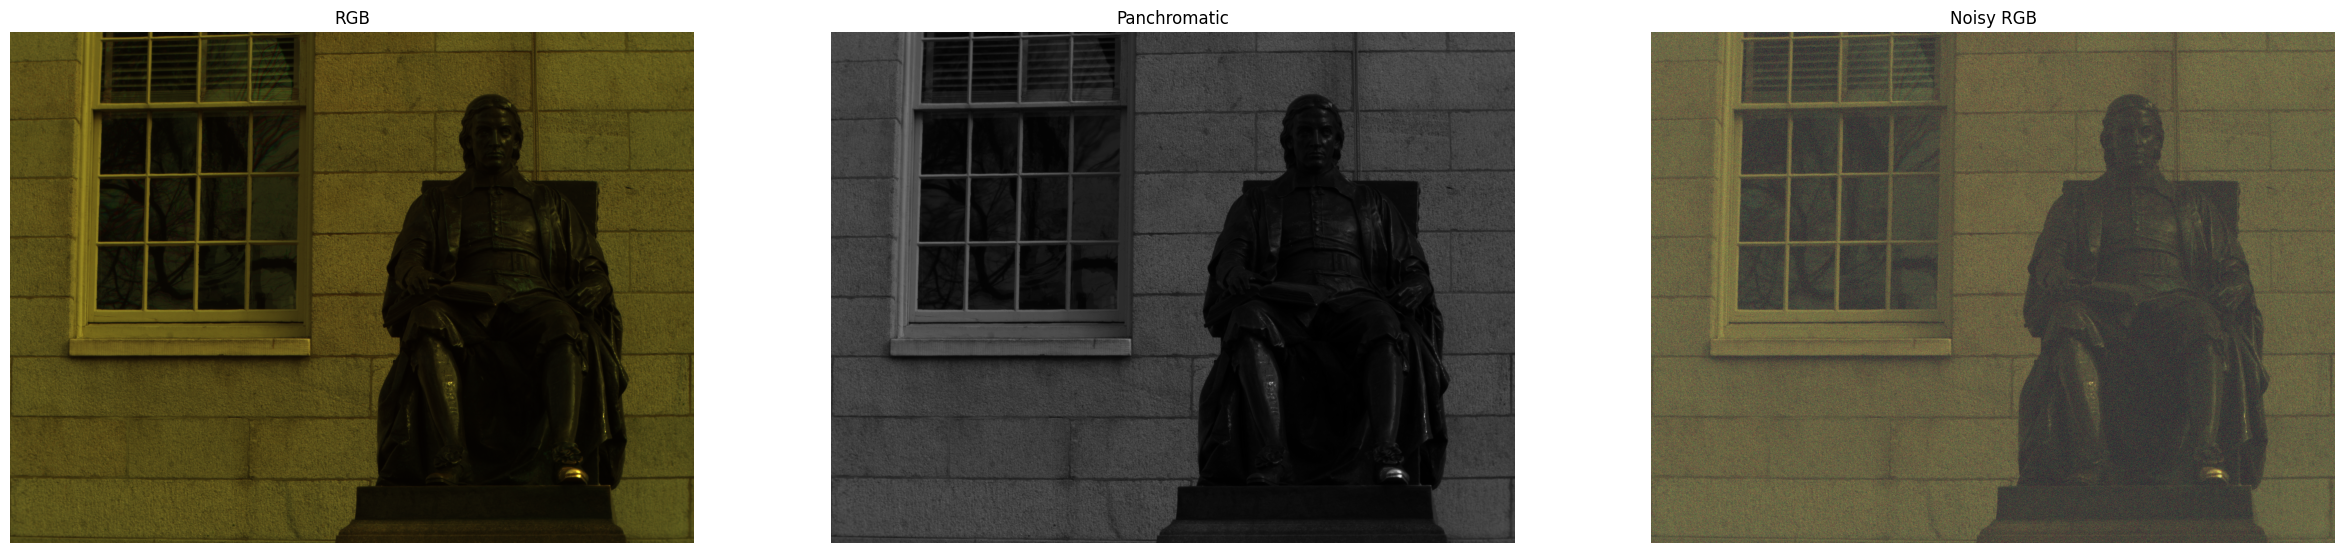

In [4]:
# Plot RGB and panchromatic 

rgb = dataset.rgb_index
x_rgb = x[0, rgb, ...].cpu().numpy().swapaxes(0, 1).swapaxes(1, 2)
x_rgb = (x_rgb - x_rgb.min())/(x_rgb.max() - x_rgb.min())

y_rgb = y[0, rgb, ...].cpu().numpy().swapaxes(0, 1).swapaxes(1, 2)
y_rgb = (y_rgb - y_rgb.min())/(y_rgb.max() - y_rgb.min())



plt.figure(figsize=(30, 10))
plt.subplot(131)
plt.imshow(x_rgb)
plt.title('RGB')
plt.axis('off')

plt.subplot(132)
plt.imshow(panc[0, 0, ...].cpu().numpy(), cmap='gray')
plt.title('Panchromatic')
plt.axis('off')

plt.subplot(133)
plt.imshow(y_rgb)
plt.title('Noisy RGB')
plt.axis('off')

plt.show()



In [5]:

# Define the solver parameters
params = {}

params['compute_L'] = {'nband': x.shape[1]}
params['K'] = {}
params['K_adjoint'] = {}
params['prox_sigma_g_conj'] = {}
params['prox_tau_f'] = {'y': y, 'sigma2': 1}
params['loss_fn'] = {}

# Define the TV prior parameters
sigma = 0.99
tau = 0.99
optim = TVPrior(max_iter=10000, lmbda=1e-2, theta=1, sigma=sigma, tau=tau)

# Run the optimization
x_est, loss = optim(y, init=None, verbose=True, params=params)

Chambolle Pock algorithm starting...
Iteration:  0 relative variation:  tensor(0.0073, device='cuda:0', dtype=torch.float64)
Cost function:  tensor(3022.3799)
Iteration:  1 relative variation:  tensor(0.0035, device='cuda:0', dtype=torch.float64)
Cost function:  tensor(2984.4111)
Iteration:  2 relative variation:  tensor(0.0017, device='cuda:0', dtype=torch.float64)
Cost function:  tensor(2965.8115)
Iteration:  3 relative variation:  tensor(0.0009, device='cuda:0', dtype=torch.float64)
Cost function:  tensor(2956.2629)
Iteration:  4 relative variation:  tensor(0.0005, device='cuda:0', dtype=torch.float64)
Cost function:  tensor(2950.9556)
Iteration:  5 relative variation:  tensor(0.0003, device='cuda:0', dtype=torch.float64)
Cost function:  tensor(2947.6379)
Iteration:  6 relative variation:  tensor(0.0002, device='cuda:0', dtype=torch.float64)
Cost function:  tensor(2945.2549)
Iteration:  7 relative variation:  tensor(0.0002, device='cuda:0', dtype=torch.float64)
Cost function:  tenso

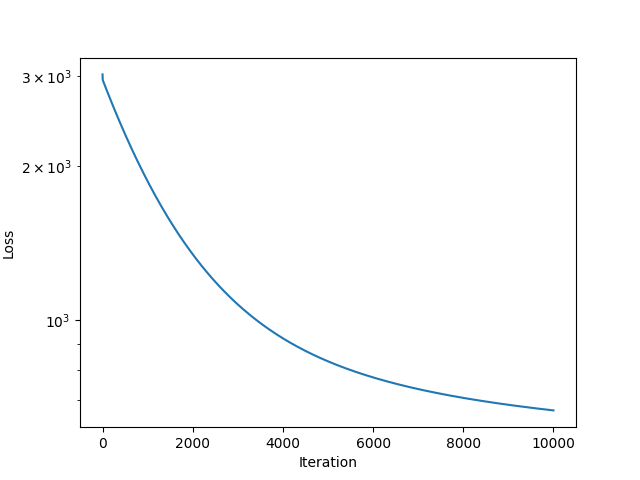

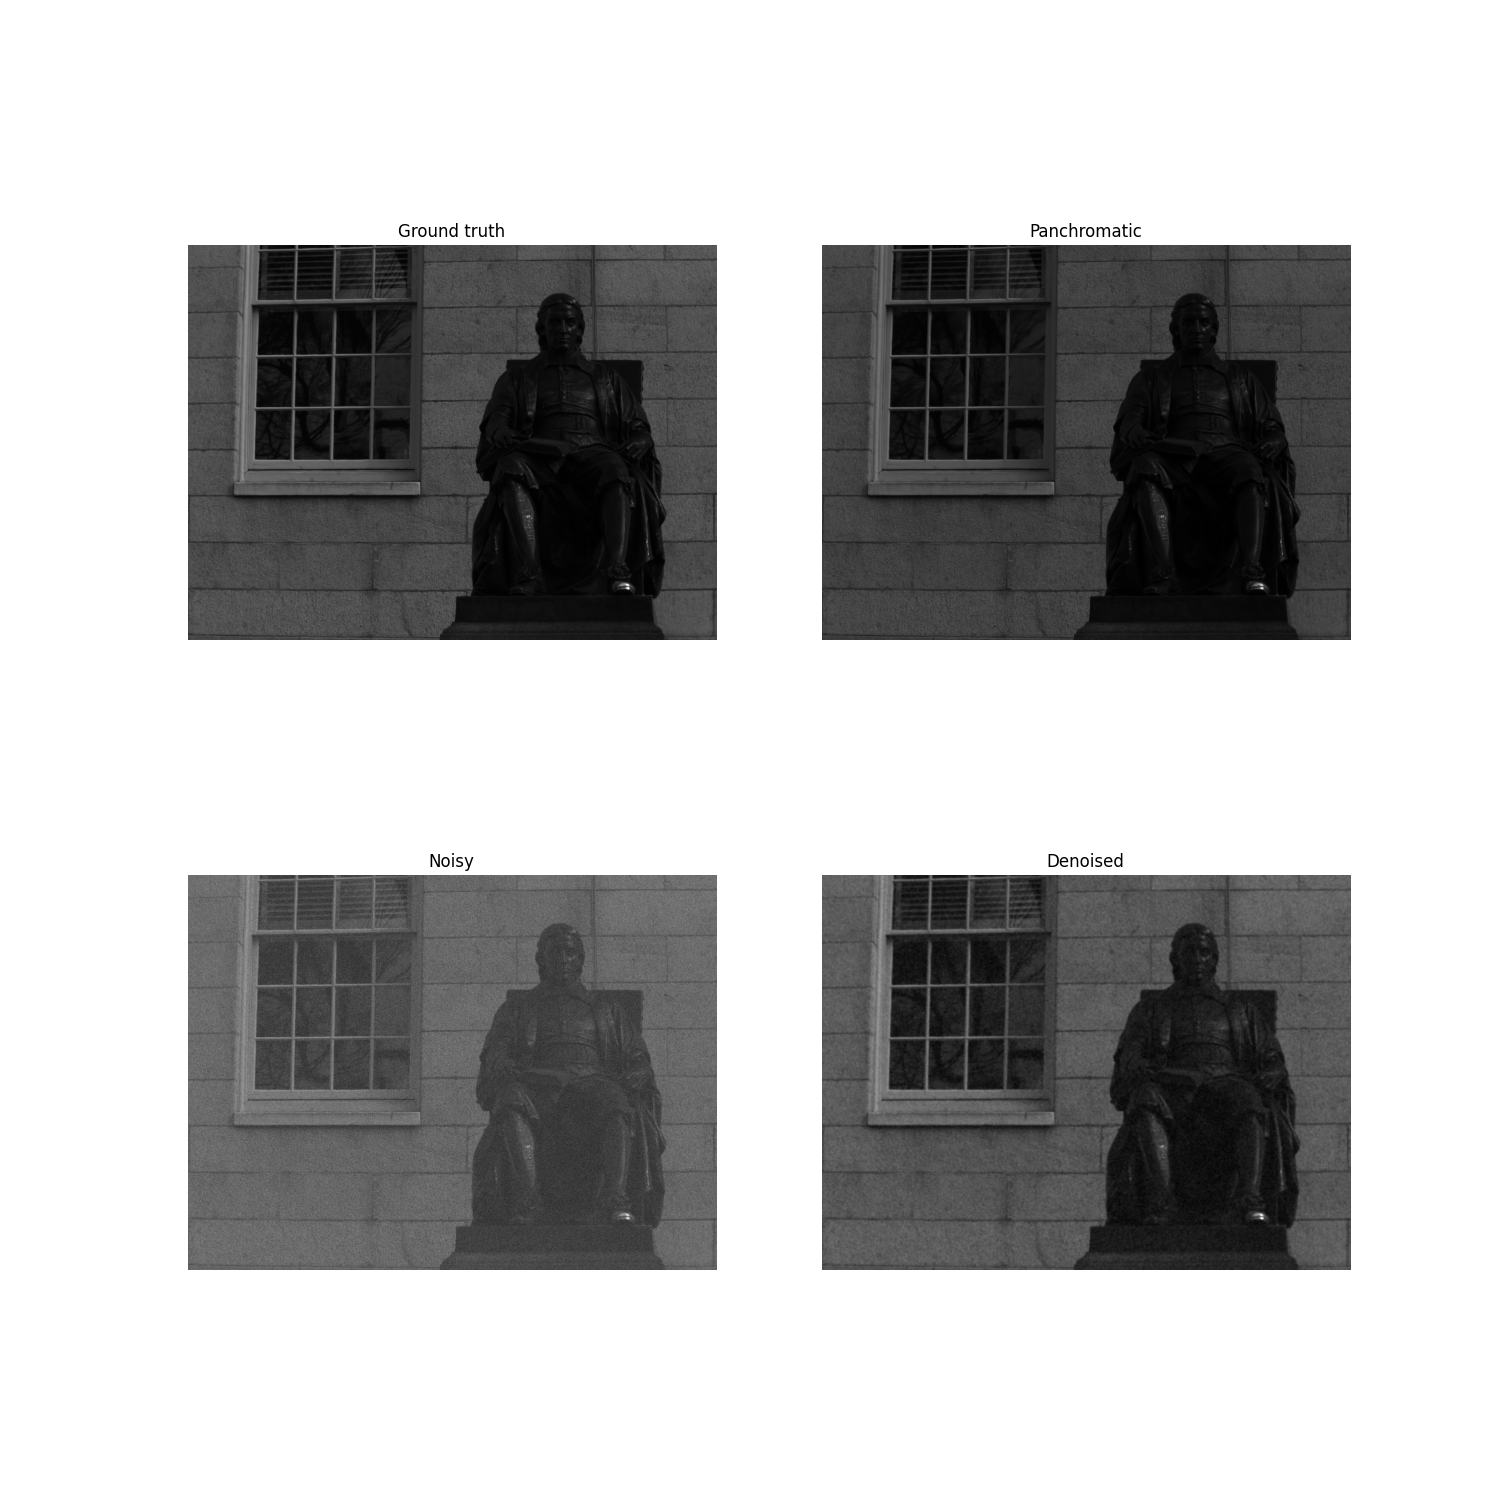

In [6]:
# Plot 
%matplotlib ipympl

band_index = 15
cmap='gray'

plt.figure(figsize=(15, 15))
plt.subplot(221)
plt.imshow(x[0, band_index, ...].cpu().numpy(), cmap=cmap)
plt.title('Ground truth')
plt.axis('off')

plt.subplot(222)
plt.imshow(panc[0, 0, ...].cpu().numpy(), cmap=cmap)
plt.title('Panchromatic')
plt.axis('off')

plt.subplot(223)
plt.imshow(y[0, band_index, ...].cpu().numpy(), cmap=cmap)
plt.title('Noisy')
plt.axis('off')

plt.subplot(224)
plt.imshow(x_est[0, band_index, ...].cpu().numpy(), cmap=cmap)
plt.title('Denoised')
plt.axis('off')



plt.figure()
plt.semilogy(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.show()

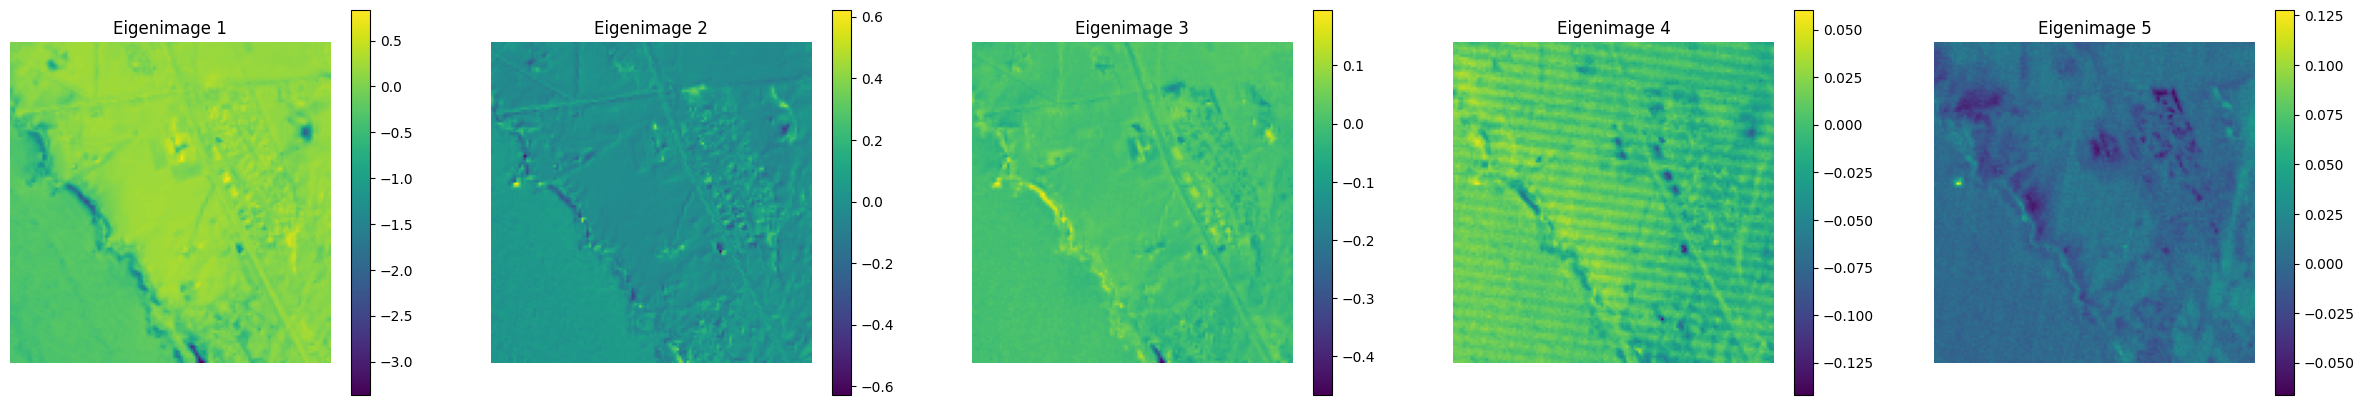

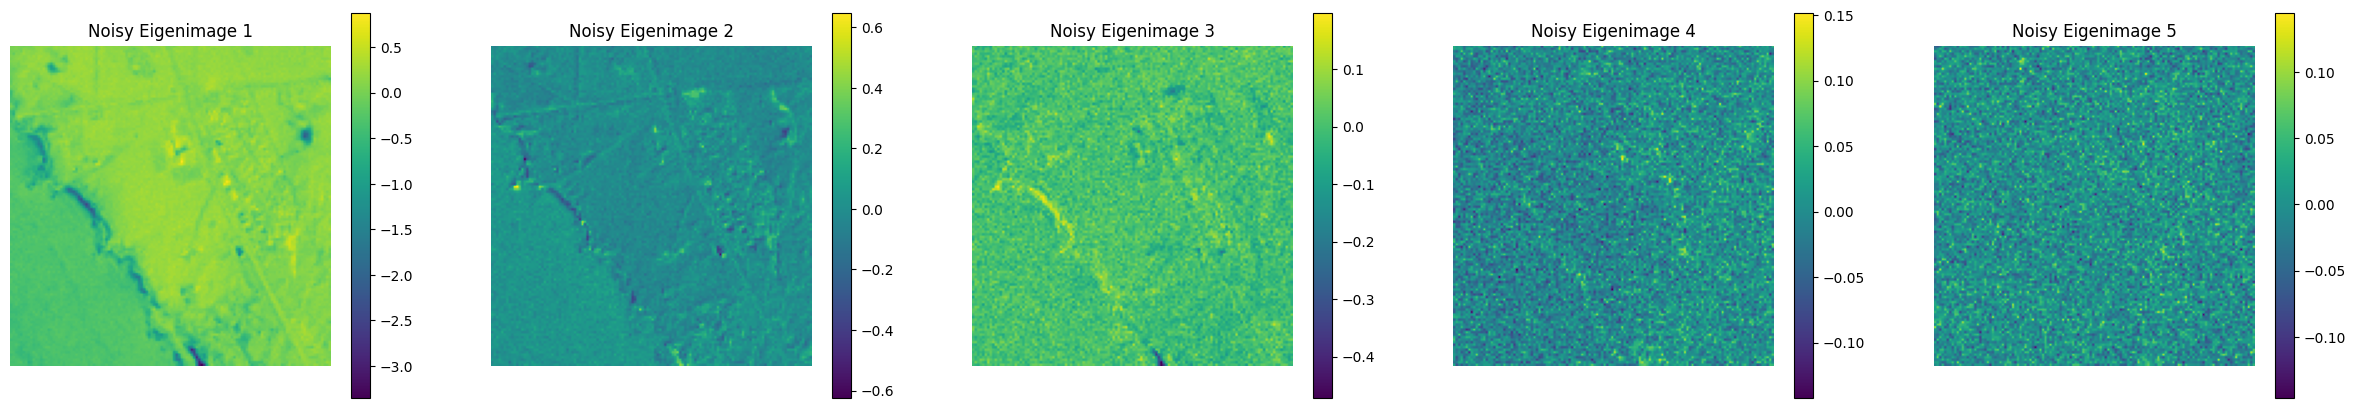

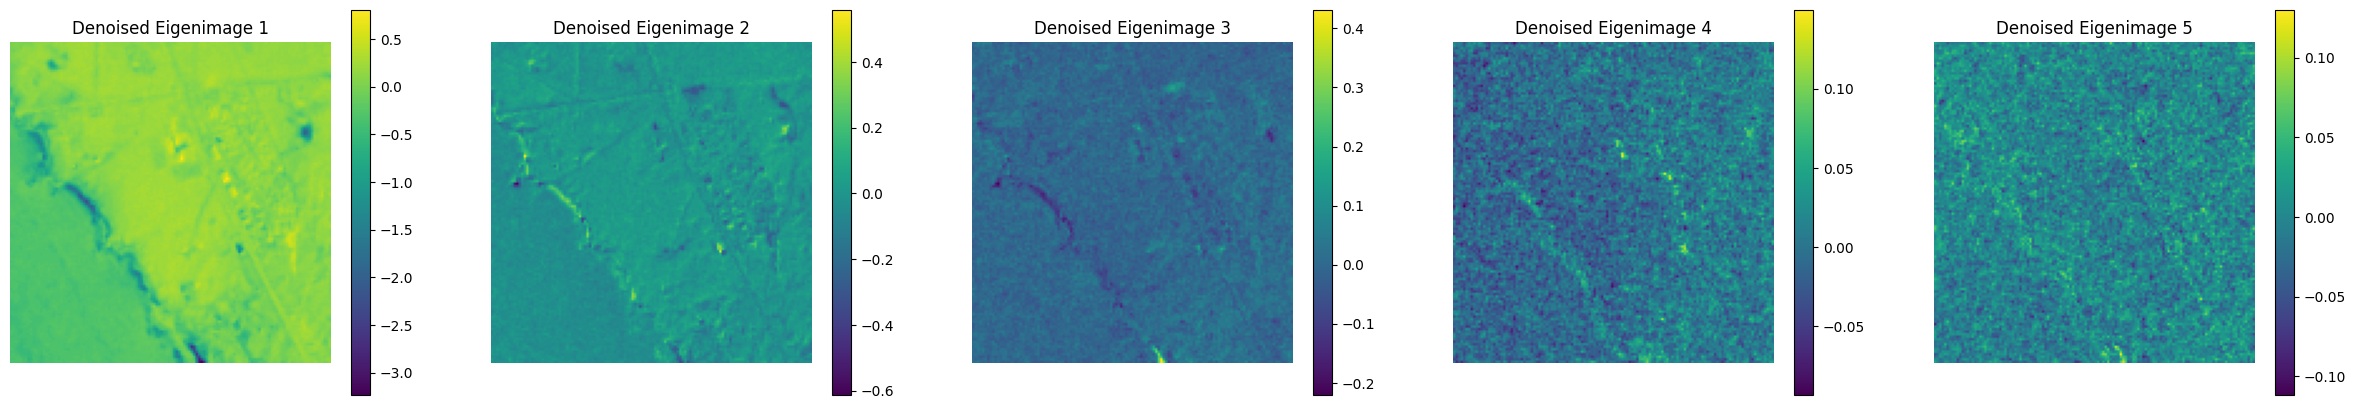

In [40]:
from datasets import get_eigenimages

z = get_eigenimages(x)
z_est = get_eigenimages(x_est)
z_noisy = get_eigenimages(y)

eigen_index = [1,3,5,7,9]


plt.figure(figsize=(30, 5))
for i, idx in enumerate(eigen_index):
    plt.subplot(151+i)
    plt.imshow(z[0, idx, ...].cpu().numpy())
    plt.colorbar()
    plt.title('Eigenimage {}'.format(i+1))
    plt.axis('off')

plt.figure(figsize=(30, 5))
for i, idx in enumerate(eigen_index):
    plt.subplot(151+i)
    plt.imshow(z_noisy[0, idx, ...].cpu().numpy())
    plt.colorbar()
    plt.title('Noisy Eigenimage {}'.format(i+1))
    plt.axis('off')

plt.figure(figsize=(30, 5))
for i, idx in enumerate(eigen_index):
    plt.subplot(151+i)
    plt.imshow(z_est[0, idx, ...].cpu().numpy())
    plt.colorbar()
    plt.title('Denoised Eigenimage {}'.format(i+1))
    plt.axis('off')

plt.show()